In [1]:
from scipy.optimize import minimize, fsolve
import datetime
import torch.nn.functional as F
from numba import njit
import time
import pandas as pd
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import pandas.api.types

import kaggle_metric_utilities

from typing import Optional


class ParticipantVisibleError(Exception):
    pass


def kl_divergence(solution: pd.DataFrame, submission: pd.DataFrame, epsilon: float, micro_average: bool, sample_weights: Optional[pd.Series]):
    # Overwrite solution for convenience
    for col in solution.columns:
        # Prevent issue with populating int columns with floats
        if not pandas.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)

        # Clip both the min and max following Kaggle conventions for related metrics like log loss
        # Clipping the max avoids cases where the loss would be infinite or undefined, clipping the min
        # prevents users from playing games with the 20th decimal place of predictions.
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        # Set the loss equal to zero where y_true equals zero following the scipy convention:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html#scipy.special.rel_entr
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1), weights=sample_weights)
    else:
        return np.average(solution.mean())


def calc_kl_score(
        #solution: pd.DataFrame,
        submission: pd.DataFrame,
        #row_id_column_name: str,
        epsilon: float=10**-15,
        micro_average: bool=True,
        sample_weights_column_name: Optional[str]=None
    ) -> float:
    ''' The Kullback–Leibler divergence.
    The KL divergence is technically undefined/infinite where the target equals zero.

    This implementation always assigns those cases a score of zero; effectively removing them from consideration.
    The predictions in each row must add to one so any probability assigned to a case where y == 0 reduces
    another prediction where y > 0, so crucially there is an important indirect effect.

    https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

    solution: pd.DataFrame
    submission: pd.DataFrame
    epsilon: KL divergence is undefined for p=0 or p=1. If epsilon is not null, solution and submission probabilities are clipped to max(eps, min(1 - eps, p).
    row_id_column_name: str
    micro_average: bool. Row-wise average if True, column-wise average if False.

    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> score(pd.DataFrame({'id': range(4), 'ham': [0, 1, 1, 0], 'spam': [1, 0, 0, 1]}), pd.DataFrame({'id': range(4), 'ham': [.1, .9, .8, .35], 'spam': [.9, .1, .2, .65]}), row_id_column_name=row_id_column_name)
    0.216161...
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> score(solution, submission, 'id')
    0.0
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0.2, 0.3, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
    >>> score(solution, submission, 'id')
    0.160531...
    '''
    #del solution[row_id_column_name]
    #del submission[row_id_column_name]

    submission = pd.DataFrame(submission.copy())
    solution = pd.DataFrame(gt.copy())

    submission = submission.rename(columns=str)
    solution = solution.rename(columns=str)

    sample_weights = None
    if sample_weights_column_name:
        if sample_weights_column_name not in solution.columns:
            raise ParticipantVisibleError(f'{sample_weights_column_name} not found in solution columns')
        sample_weights = solution.pop(sample_weights_column_name)

    if sample_weights_column_name and not micro_average:
        raise ParticipantVisibleError('Sample weights are only valid if `micro_average` is `True`')

    for col in solution.columns:
        if col not in submission.columns:
            raise ParticipantVisibleError(f'Missing submission column {col}')

    kaggle_metric_utilities.verify_valid_probabilities(solution, 'solution')
    kaggle_metric_utilities.verify_valid_probabilities(submission, 'submission')


    #return kaggle_metric_utilities.safe_call_score(kl_divergence, solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)
    return kaggle_metric_utilities.safe_call_score(kl_divergence, solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

In [3]:
def calc_score(y_pred):
    return calc_kl_score(y_pred)

def func_to_optimise(weights):
    pred_blend = np.tensordot(weights, preds, axes = ((0), (0)))
    score = calc_score(pred_blend)
    return score

In [4]:
TARGET = [str(i) for i in range(6)]

In [5]:
itk009 = pd.read_csv('res009/oof_ema.csv')[TARGET]
itk010 = pd.read_csv('res010/oof_ema.csv')[TARGET]
itk014 = pd.read_csv('res014/oof_ema_14.csv')[TARGET]
itk009.head()

,0,1,2,3,4,5
0,0.002031,0.002744,0.000507,0.013308,0.143733,0.837677
1,0.005207,0.081833,0.028754,0.134870,0.014029,0.735306
2,0.022369,0.498195,0.000466,0.202691,0.012980,0.263298
3,0.053309,0.117337,0.219126,0.032437,0.227241,0.350550
4,0.014600,0.698387,0.012280,0.055857,0.032832,0.186044


In [6]:
gt = pd.read_csv('res009/gt.csv')[TARGET]
gt.head()

,0,1,2,3,4,5
0,0.0,0.000000,0.0,0.000000,0.0,1.000000
1,0.0,0.333333,0.0,0.000000,0.0,0.666667
2,0.0,0.000000,0.0,1.000000,0.0,0.000000
3,0.0,0.000000,0.0,0.000000,1.0,0.000000
4,0.0,0.785714,0.0,0.142857,0.0,0.071429


In [7]:
preds_dict = {
    'itk_009': itk009,
    'itk_010': itk010,
    'itk_014': itk014,
}

In [8]:
preds = np.zeros((len(preds_dict), len(gt), 6))
for i in range(preds.shape[0]):
    preds[i] = list(preds_dict.values())[i]

In [9]:
%%time

kl_scores = {}
for n, key in enumerate(preds_dict.keys()):
    score_val = calc_score(preds[n])
    kl_scores[key] = score_val
    print(f'{key:40s} KLD_Loss:', score_val)
    
print('-' * 60)

itk_009                                  KLD_Loss: 0.5475537147321641
itk_010                                  KLD_Loss: 0.5493073973918222
itk_014                                  KLD_Loss: 0.5425283404735844
------------------------------------------------------------
CPU times: user 59.9 ms, sys: 98 µs, total: 60 ms
Wall time: 59.5 ms


0 itk_009
1 itk_010
2 itk_014


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

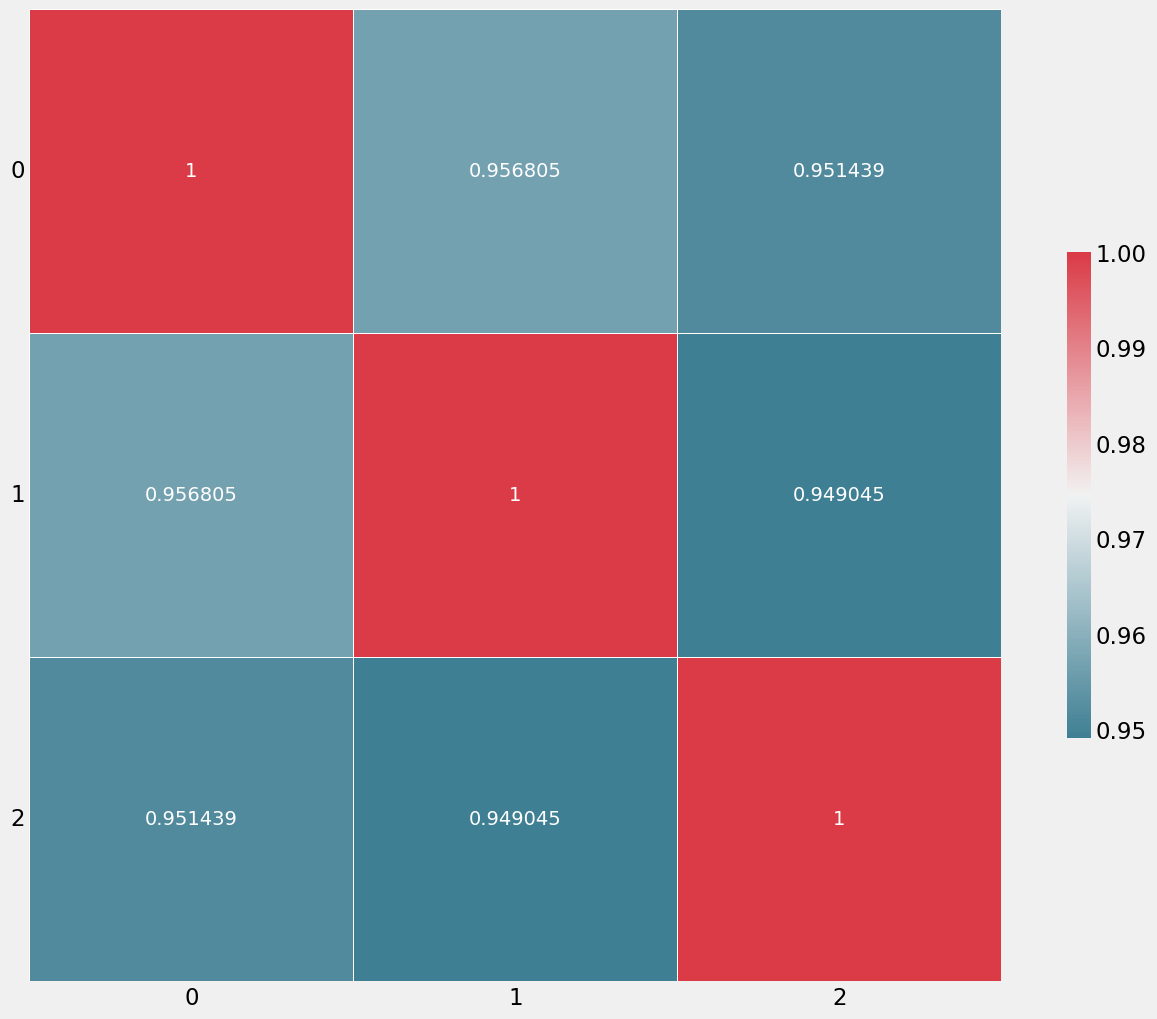

In [10]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('fivethirtyeight')

subs = np.zeros((len(preds_dict), len(gt), 6))

for i, p in enumerate(preds_dict.keys()):
    print(i,p)
    subs[i,:,:] = list(preds_dict.values())[i]
    
corr = np.corrcoef(subs.reshape(len(preds_dict), -1))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, annot=True, fmt="g",
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set_ylim(corr.shape[0], 0)
plt.yticks(rotation=0)

In [11]:
tol = 1e-10
init_guess = [1 / preds.shape[0]] * preds.shape[0]
bnds = [(0, 1) for _ in range(preds.shape[0])]
cons = {'type': 'eq', 
        'fun': lambda x: np.sum(x) - 1, 
        'jac': lambda x: [1] * len(x)}

print('Inital Blend KLD:', func_to_optimise(init_guess))
start_time = time.time()

res_scipy = minimize(fun = func_to_optimise, 
                     x0 = init_guess, 
                     method = 'SLSQP', 
                     tol = tol,
                     bounds = bnds,
                     #jac = grad_func_jit, 
                     constraints = cons,
                     options={"disp":True,"maxiter":1000})

print(f'[{str(datetime.timedelta(seconds = time.time() - start_time))[2:7]}] Optimised Blend Loss:', res_scipy.fun, ', Optimised Blend KLD_Loss:', func_to_optimise(res_scipy.x))
print('Optimised Weights:', res_scipy.x)
print('-' * 70)

for n, key in enumerate(preds_dict.keys()):
    print(f'{key:40s} Optimised Weights:', res_scipy.x[n])

Inital Blend KLD: 0.5155936111163437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5154752712217557
            Iterations: 10
            Function evaluations: 40
            Gradient evaluations: 10
[00:01] Optimised Blend Loss: 0.5154752712217557 , Optimised Blend KLD_Loss: 0.5154752712217557
Optimised Weights: [0.30376698 0.3221606  0.37407242]
----------------------------------------------------------------------
itk_009                                  Optimised Weights: 0.3037669760587401
itk_010                                  Optimised Weights: 0.32216060277245323
itk_014                                  Optimised Weights: 0.37407242116880673


In [12]:
ws = [res_scipy.x[i] for i in range(len(preds_dict.keys()))]
ws = ws / np.sum(ws)
ws

array([0.30376698, 0.3221606 , 0.37407242])